In [201]:
import os
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import xgboost as xgb
import numpy as np
from scipy.stats import uniform, randint
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
     accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

#progress bar
from tqdm import trange
from tqdm import tqdm

In [202]:
torch.set_default_dtype(torch.float32)

In [203]:
use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)

Using device cuda:0


In [204]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

data = pd.read_csv("/kaggle/input/airbnbdata-barcelona/listing_data_lower_dimension.csv")
data = data.select_dtypes(exclude=['object', 'string']).dropna(subset=['price', 'id'])

X = data.drop(columns=['price','id'])
y = data['price']

# --- 1) Split as before ---
X_train_df, X_test_df, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- 2) Impute, but don’t overwrite the DataFrames! ---
imputer = SimpleImputer(strategy='median')

# Fit on the DataFrame’s values and get back NumPy arrays
X_train_imp = imputer.fit_transform(X_train_df)
X_test_imp  = imputer.transform(X_test_df)

# --- 3) Re‑wrap into DataFrames using the *original* indices ---
cols = X.columns
X_train = pd.DataFrame(X_train_imp, columns=cols, index=X_train_df.index)
X_test  = pd.DataFrame(X_test_imp,  columns=cols, index=X_test_df.index)

In [205]:
from xgboost import XGBRegressor

my_model = XGBRegressor(
    objective='reg:squarederror',
    tree_method='gpu_hist',
    verbosity=0,       # 0 = silent, 1 = warning, 2 = info, 3 = debug
    random_state=42,
    early_stopping_rounds = 10,
)

param_dist = {
    'max_depth':        randint(12, 17),
    'learning_rate':    uniform(0.005, 0.015),
    'n_estimators':     randint(1000, 2000),
    'subsample':        uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 10),        # minimum loss reduction to make a split
    'reg_alpha': uniform(0, 5),    # L1 regularization
    'reg_lambda': uniform(0, 5),   # L2 regularization
}

random_search = RandomizedSearchCV(
    estimator=my_model,
    param_distributions=param_dist,
    n_iter= 50,                         # wie viele Kombinationen wir testen
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1,
    refit = True
)
random_search.fit(
            X_train, y_train, 
            eval_set=[(X_test, y_test)], 
            verbose=False)

print("\n=== RandomizedSearchCV ===")
print("Best Params:", random_search.best_params_)
print("Best RMSE (CV):", -random_search.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits

=== RandomizedSearchCV ===
Best Params: {'colsample_bytree': 0.6061218161161539, 'gamma': 9.33436308079483, 'learning_rate': 0.012515598258728888, 'max_depth': 16, 'n_estimators': 1515, 'reg_alpha': 3.079255821949569, 'reg_lambda': 4.719458022803786, 'subsample': 0.977700638850067}
Best RMSE (CV): 271.7202740434013


In [211]:
import pandas as pd

# 1) Convert the cv_results_ dict into a DataFrame
cv_results = pd.DataFrame(random_search.cv_results_)

# 2) Sort by the rank (1 = best) so the top rows are your best trials
cv_results = cv_results.sort_values('rank_test_score')

# 3) Select the columns you want to see
cols_of_interest = [
    'rank_test_score',
    'mean_test_score',
    'std_test_score',
    'param_max_depth',
    'param_learning_rate',
    'param_n_estimators',
    'param_subsample',
    'param_colsample_bytree'
]

# 4) Display the top 10
print(cv_results[cols_of_interest].head(10))

    rank_test_score  mean_test_score  std_test_score param_max_depth  \
47                1      -271.720274       40.022852              16   
6                 2      -271.744572       40.135813              13   
20                3      -271.858370       40.568498              13   
46                4      -272.037455       40.638150              13   
4                 5      -272.115788       40.667564              15   
18                6      -272.131556       40.963430              12   
26                7      -272.199882       40.533720              12   
45                8      -272.319514       40.248168              16   
14                9      -272.527285       39.580031              14   
1                10      -272.907569       40.374283              16   

   param_learning_rate param_n_estimators param_subsample  \
47            0.012516               1515        0.977701   
6             0.011377               1771        0.910053   
20            0.008593  

In [212]:
best_model = random_search.best_estimator_  
y_pred_tuned = best_model.predict(X_test_imp)

In [225]:
def evaluate_model(model, X_test, y_test):
    """
    Führt Vorhersage auf X_test durch und berechnet verschiedene Kennzahlen.
    Gibt y_pred zurück, damit du es z.B. für Plots weiterverwenden kannst.
    """
    # 1) Vorhersagen
    y_pred = model.predict(X_test)

    # 2) Metriken berechnen
    mse  = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)

    abs_err = abs(y_pred - y_test)

    # 3) Ausgabe
    print(f"MSE:  {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R²:   {r2:.4f}")

    return y_pred, abs_err

In [226]:
from xgboost import plot_importance
from sklearn.model_selection import learning_curve
def plot_accuracy(y_true, y_pred):
    """
    Zeichnet:
      1) True-vs-Predicted-Scatter mit 45°-Linie
      2) Residual-Distribution (Histogramm)

    """


    cv_df = pd.DataFrame(random_search.cv_results_)
    # 2) Convert negative RMSE back to positive
    cv_df['cv_rmse'] = -cv_df['mean_test_score']
    
    # 3) Scatter‑plot max_depth against CV RMSE
    plt.figure(figsize=(8, 5))
    plt.scatter(cv_df['param_max_depth'], cv_df['cv_rmse'])
    plt.xlabel('max_depth')
    plt.ylabel('CV RMSE')
    plt.title('max_depth vs. CV RMSE')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


    cv_df = pd.DataFrame(random_search.cv_results_)
    plt.scatter(cv_df['param_learning_rate'], -cv_df['mean_test_score'])
    plt.xlabel('learning_rate'); plt.ylabel('CV RMSE'); plt.show()
    # 1) Absolute Errors berechnen
    abs_errors = np.abs(y_test - y_pred)
#    plt.figure(figsize=(8,5))
#    plt.hist(abs_errors, bins=30, edgecolor='k', alpha=0.7,
#             weights=np.ones_like(abs_errors)/len(abs_errors)*100)
#    plt.xlim(0, 500)  # Fokus auf Fehler bis 500
#    plt.xlabel('Absolute Error')
#    plt.ylabel('Percentage (%)')
#    plt.title('Absolute Errors (0–500)')
#    plt.grid(True, linestyle='--', alpha=0.7)
#    plt.tight_layout()


    threshold = np.percentile(abs_errors, 95)
    errs_clip = abs_errors[abs_errors <= threshold]
    plt.figure(figsize=(8,5))
    plt.hist(errs_clip, bins=30, edgecolor='k', alpha=0.7,
             weights=np.ones_like(errs_clip)/len(abs_errors)*100)
    plt.xlabel(f'Absolute Error (bis {threshold:.0f})')
    plt.ylabel('Percentage (%)')
    plt.title(f'Errors bis zum 95. Perzentil ({threshold:.0f})')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


    
    # Scatter True vs Predicted
    plt.figure(figsize=(6,6))
    lims = [min(min(y_true), min(y_pred)), max(max(y_true), max(y_pred))]
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot(lims, lims, 'k--', linewidth=1)
    plt.xlabel("True Values")
    plt.xlim(0, 500)
    plt.ylim(0, 500)
    plt.ylabel("Predicted Values")
    plt.title("True vs. Predicted")
    plt.tight_layout()
    plt.show()

#
#    plt.figure(figsize=(8,5))
#    plt.hist(y_test,  bins=30, alpha=0.5, label='True Values')
#    plt.hist(y_pred,  bins=30, alpha=0.5, label='Predicted Values')
#    plt.xlabel('Preis')
 #   plt.ylabel('Häufigkeit')
#    plt.title('Histogramm: True vs. Predicted')
#    plt.legend()
#    plt.tight_layout()

    # Histogramm der Residuen
#    residuals = y_true - y_pred
#    plt.figure(figsize=(6,4))
#    plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
#    plt.xlabel("Residual (True – Predicted)")
#    plt.ylabel("Frequency")
#    plt.title("Residual Distribution")
#    plt.tight_layout()





    
    plot_importance(best_model, max_num_features=10, importance_type='gain')
    plt.show()

In [227]:
def plot_accuracy2(errors, bins = 10, min_range = None, max_range = None, title=""):

    if min_range is None:
        min_range = min(errors)
    if max_range is None:
        max_range = max(errors)

    counts, bin_edges = np.histogram(errors, bins=bins, range=(min_range, max_range))

    percentages = 100 * counts / counts.sum()

    bin_widths = bin_edges[1:] - bin_edges[:-1]

    plt.bar(bin_edges[:-1], percentages, width = bin_widths, align = 'edge', edgecolor='black')
    plt.xlabel("Absolute Error")
    plt.ylabel("Percentage (%)")
    plt.title("Percentage Distribution of " + title)

    #plt.hist(errors, bins, range=(min_range, max_range), density=True)
    plt.grid(True)
    plt.show()

MSE:  158364.0040
RMSE: 397.9498
MAE:  75.2069
R²:   0.1227


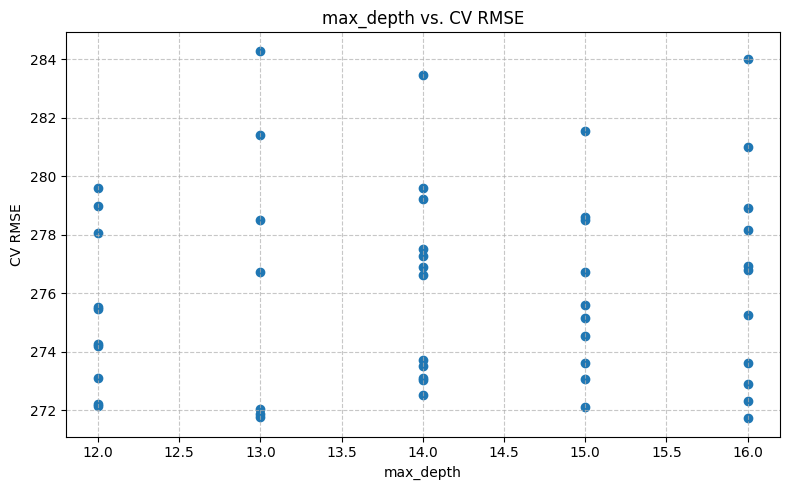

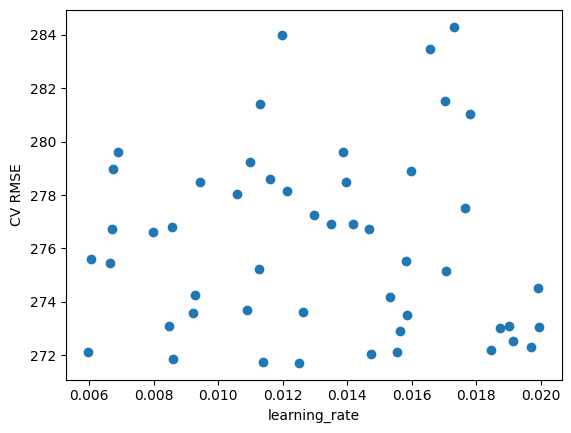

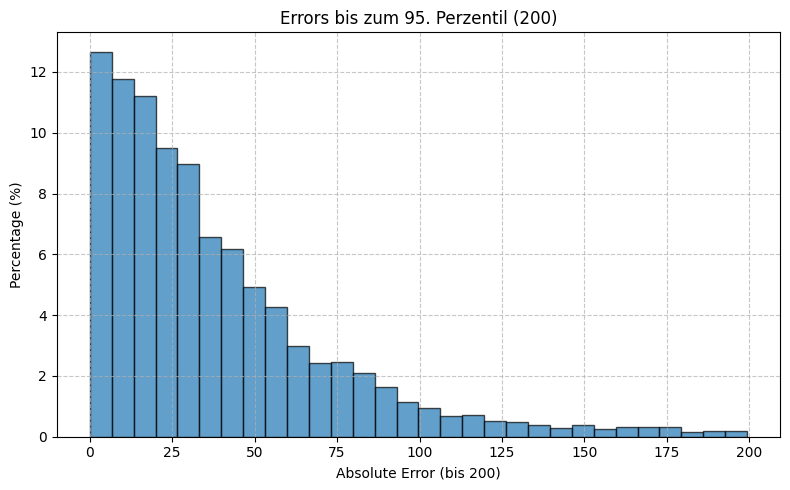

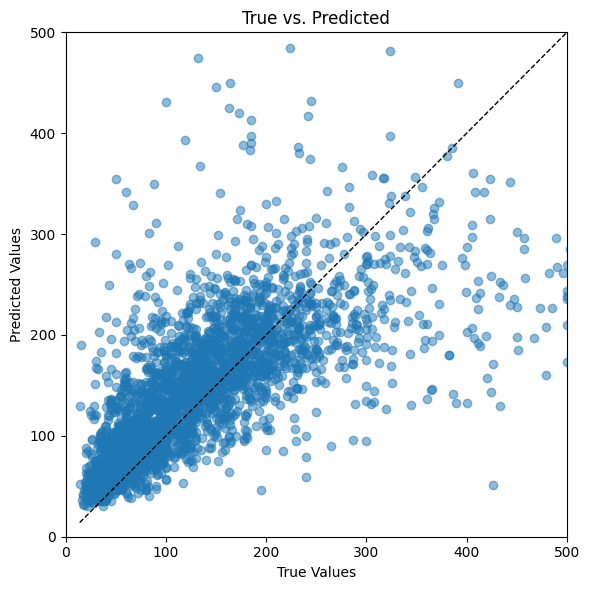

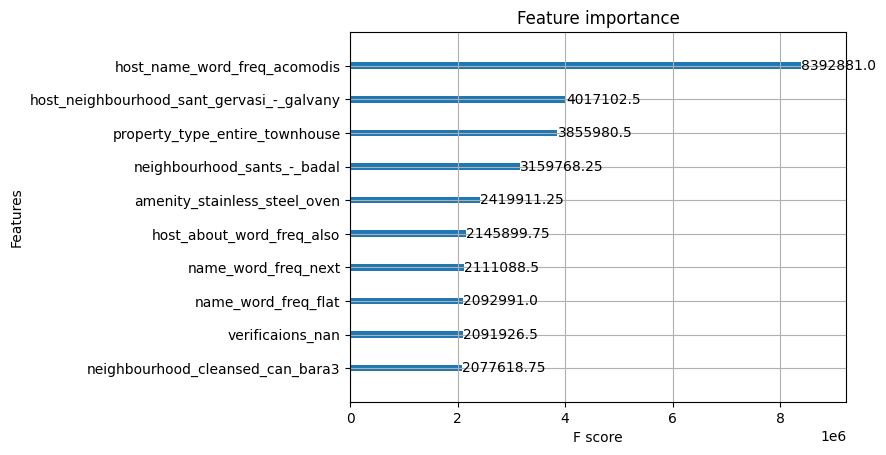

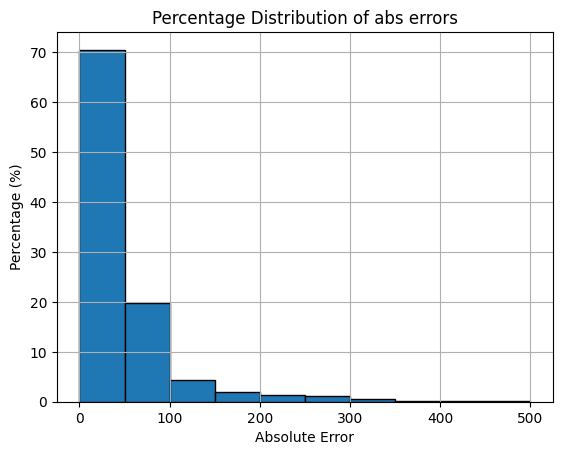

In [229]:
#evaluate
_,abs_err= evaluate_model(best_model, X_test, y_test)
plot_accuracy(y_test, y_pred_tuned)
plot_accuracy2(abs_err, bins = 10, min_range = 0, max_range = 500, title="abs errors")
